In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

In [7]:
TMQRPATH = os.getenv("TMQRPATH", '')

swarms = {}
for file in os.listdir(os.path.join(TMQRPATH, 'swarms')):
    swarm_name = file.replace('.swm','')
    print('Loading: '+ swarm_name)
    swarms[swarm_name] = Swarm.load(os.path.join(TMQRPATH, 'swarms', file))

Loading: EP_RatioPutSpread_Long_SwingPoint
Loading: EP_RatioPutSpread_Long_BollingerBands
Loading: EP_RatioPutSpread_Short_BollingerBands
Loading: EP_RatioPutSpread_Long_PointAndFigurePatterns
Loading: EP_RatioPutSpread_Short_PointAndFigurePatterns
Loading: EP_RatioPutSpread_Short_SwingPoint
Loading: EP_RatioPutSpread_Long_MACross
Loading: EP_RatioPutSpread_Short_IchimokuCloud
Loading: EP_RatioPutSpread_Short_MACross
Loading: EP_RatioPutSpread_Long_VolatilityCompression
Loading: EP_RatioPutSpread_Short_VolatilityCompression
Loading: EP_RatioPutSpread_Long_IchimokuCloud


### Available swarms

In [8]:
print("Swarms list:")
for swarm_name in sorted(swarms.keys()):
    print(swarm_name)

Swarms list:
EP_RatioPutSpread_Long_BollingerBands
EP_RatioPutSpread_Long_IchimokuCloud
EP_RatioPutSpread_Long_MACross
EP_RatioPutSpread_Long_PointAndFigurePatterns
EP_RatioPutSpread_Long_SwingPoint
EP_RatioPutSpread_Long_VolatilityCompression
EP_RatioPutSpread_Short_BollingerBands
EP_RatioPutSpread_Short_IchimokuCloud
EP_RatioPutSpread_Short_MACross
EP_RatioPutSpread_Short_PointAndFigurePatterns
EP_RatioPutSpread_Short_SwingPoint
EP_RatioPutSpread_Short_VolatilityCompression


### Available EXOs

In [9]:
passive_exo = {}


print('Passive EXO list')
for matfile in os.listdir(os.path.join(TMQRPATH, 'mat')):    
    if 'strategy_' in matfile and '.mat' in matfile:
        exo = EXOInfo.from_matfile(os.path.join(TMQRPATH, 'mat', matfile))
        passive_exo[exo.exo_name()] = exo.exo_price_index()    

for exo in sorted(passive_exo.keys()):
    print(exo)

Passive EXO list
CLE_CLE_BullishCall_EXO
CLE_CLE_CallSpread_EXO
EP_EP_BearishCollarBrokenWing_EXO
EP_EP_BearishCollar_EXO
EP_EP_BullishCall_EXO
EP_EP_BullishCollar_EXO
EP_EP_RatioPutSpread_EXO
EU6_EU6_BearishCollarBrokenWing_EXO
EU6_EU6_BearishVolStrangle_EXO
JY6_JY6_BullishCall_EXO
JY6_JY6_BullishVolStrangle_EXO
NGE_NGE_CallSpread_EXO
ZLE_ZLE_BullishCollar_EXO


# Campaign composition

Copy/paste EXO or swarm names to the 'campaign_exposure' dictionary from lists above

In [10]:
campaign_exposure = {
     'EP_RatioPutSpread_Long_BollingerBands': 1,
     'EP_RatioPutSpread_Short_IchimokuCloud': 1,
     #'EP_BearishCollarBrokenWing_SwingPoint_Short': 1,
     
     #
     # Passive EXO positions
     #
     'EP_BullishCollar_EXO': -1, # Short 1 EXO units
     
}

In [16]:
#def campaign_equity(swarms, exposure):

campaign_dict = {}
campaign_stats = {'NetProfit': 0.0, 'TradesCount': 0, 'CommissionSum': 0.0}

for camp_name, exposure in campaign_exposure.items():
    if camp_name in swarms:
        swarm_name = camp_name
        smgr = swarms[swarm_name]
        campaign_dict[swarm_name] = smgr.picked_equity
        
        # TODO: implement swarm statistics
        '''
        s = smgr.picked_stats        
        campaign_stats['NetProfit'] += s['NetProfit']
        campaign_stats['TradesCount'] += s['TradesCount']
        campaign_stats['CommissionSum'] += s['CommissionSum']
        '''
        
    elif camp_name in passive_exo:
        exo_equity = passive_exo[camp_name]
        campaign_dict[camp_name] = exo_equity.diff() * exposure
    
    
campaign_portfolio = pd.DataFrame(campaign_dict)
campaign_equity = campaign_portfolio.sum(axis=1)

### Campaign members equities

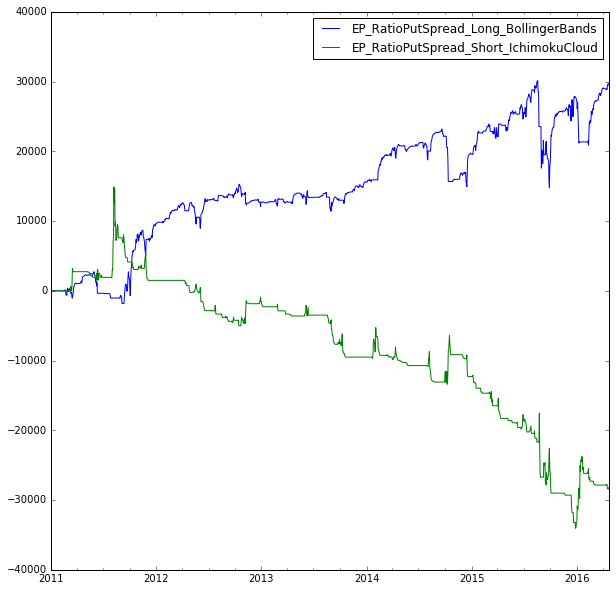

In [17]:
figsize(10,10)
campaign_portfolio.plot()

### Cumulative campaign equity

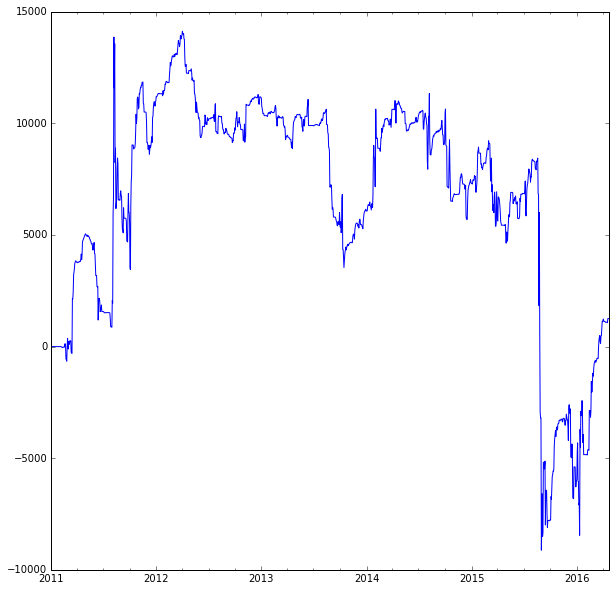

In [18]:
campaign_portfolio.sum(axis=1).plot()

# Campaign statistics

In [19]:
print(campaign_stats)

{'NetProfit': 0.0, 'TradesCount': 0, 'CommissionSum': 0.0}
